# Homework 4
### CSE 802
### David Rackerby

1. The IMOX dataset consists of 192 8-dimensional patterns pertaining to four classes (digital characters
‘I’, ‘M’, ‘O’ and ‘X’). There are 48 patterns per class. The 8 features correspond to the distance of a
character to the (a) upper left boundary, (b) lower right boundary, (c) upper right boundary, (d) lower
left boundary, (e) middle left boundary, (f) middle right boundary, (g) middle upper boundary, and (h)
middle lower boundary. Note that the class labels (1, 2, 3 or 4) are indicated at the end of every pattern.

(a) [4 points]Write a program to project these 8-dimensional points onto a two dimensional plane
using PCA (the top 2 eigenvectors). Report the two projection vectors estimated by the technique.
Plot the entire dataset in two dimensions using these projection vectors. Use different markers to
distinguish the patterns belonging to different classes.

Projection vectors (column vectors):
[[-0.21534345 -0.27405584]
 [-0.43149547  0.12969441]
 [ 0.01447815 -0.16398584]
 [-0.36999766 -0.17686048]
 [-0.47631268 -0.48645337]
 [ 0.48849912 -0.46809659]
 [ 0.38713671  0.01955831]
 [ 0.1222742  -0.62750932]]


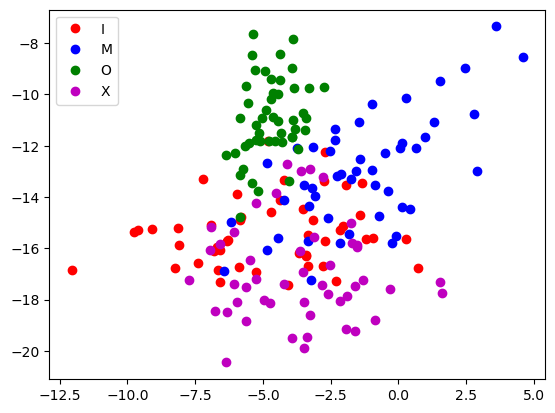

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

imox_data = pd.read_fwf('imox_data.txt', header=None)
labels = imox_data[8]
imox_unlabeled = imox_data.drop(labels=8, axis=1)

def get_mean(data: pd.DataFrame) -> np.ndarray:
    return data.sum(axis=0).apply(lambda x: x / len(data)).to_numpy()

global_mean = get_mean(imox_unlabeled)

def get_scatter(mean: np.ndarray, data: pd.DataFrame) -> np.ndarray:
    scatter = np.zeros((len(mean), len(mean)))
    for vec in data.to_numpy():
        x = np.atleast_2d(vec - global_mean)
        scatter += x.T @ x
    return scatter

global_scatter = get_scatter(global_mean, imox_unlabeled)

eig_val, eig_vec = np.linalg.eig(global_scatter)
val_vec_pairs = list(zip(eig_val, eig_vec))
val_vec_pairs.sort(reverse=True, key=lambda pair: pair[0])

top_2_vecs = val_vec_pairs[:2]
eigenmatrix = np.vstack((top_2_vecs[0][1], top_2_vecs[1][1]))
print(f'Projection vectors (column vectors):\n{eigenmatrix.T}')

projected_points = []
for i, vec in enumerate(imox_unlabeled.to_numpy()):
    projected_points.append((labels[i], eigenmatrix @ vec))

I_points = np.array([vec for i, vec in projected_points if i == 1])
M_points = np.array([vec for i, vec in projected_points if i == 2])
O_points = np.array([vec for i, vec in projected_points if i == 3])
X_points = np.array([vec for i, vec in projected_points if i == 4])
plt.plot(I_points[:, 0], I_points[:, 1], 'ro', label='I')
plt.plot(M_points[:, 0], M_points[:, 1], 'bo', label='M')
plt.plot(O_points[:, 0], O_points[:, 1], 'go', label='O')
plt.plot(X_points[:, 0], X_points[:, 1], 'mo', label='X')
plt.legend()
plt.show()


(b) [4 points]Write a program to project these 8-dimensional points onto a two dimensional plane
using MDA (the top 2 eigenvectors). Report the two projection vectors estimated by the technique.
Plot the entire dataset in two dimensions using these projection vectors. Use different markers to
distinguish the patterns belonging to different classes.

In [67]:
I_data = imox_data[imox_data[8] == 1].drop(labels=8, axis=1)
M_data = imox_data[imox_data[8] == 2].drop(labels=8, axis=1)
O_data = imox_data[imox_data[8] == 3].drop(labels=8, axis=1)
X_data = imox_data[imox_data[8] == 4].drop(labels=8, axis=1)

I_mean = get_mean(I_data)
M_mean = get_mean(M_data)
O_mean = get_mean(O_data)
X_mean = get_mean(X_data)

I_scatter = get_scatter(I_mean, I_data)
M_scatter = get_scatter(M_mean, M_data)
O_scatter = get_scatter(O_mean, O_data)
X_scatter = get_scatter(X_mean, X_data)

within_class_scatter = I_scatter + M_scatter + O_scatter + X_scatter

between_class_scatter = np.zeros((len(global_mean), len(global_mean)))

for data, mean in [(I_data, I_mean), (M_data, M_mean), (O_data, O_mean), (X_data, X_mean)]:
    x = np.atleast_2d(mean - global_mean)
    between_class_scatter += len(data) * (x.T @ x)




48

6. [Bonus Question: 20 points]The iris (flower) dataset consists of 150 4-dimensional patterns belonging
to three classes (setosa=1, versicolor=2, and virginica=3). There are 50 patterns per class. The 4
features correspond to (a) sepal length in cm, (b) sepal width in cm, (c) petal length in cm, and (d)
petal width in cm. Note that the class labels are indicated at the end of every pattern.
Design a K-NN classifier for this dataset. You can use the Euclidean distance metric for computing
distances. Choose the first 25 patterns of each class for training the classifier (i.e., these are the proto-
types) and the remaining 25 patterns of each class for testing the classifier. [Note: Any ties in the K-NN
classification scheme should be broken at random.]

(a) In order to study the effect of K on the performance of the classifier, report the confusion matrix
for K=1,5,10,15,20,25,30,35,40,45,50.

In [125]:
from sklearn import datasets

iris_df, _ = datasets.load_iris(return_X_y=True, as_frame=True)
setosa = iris_df.iloc[:50]
versicolor = iris_df.iloc[50:100]
virginica = iris_df.iloc[100:]

train = pd.concat([setosa.iloc[:25], versicolor.iloc[:25], virginica.iloc[:25]])
test = pd.concat([setosa.iloc[25:], versicolor.iloc[25:],
                   virginica.iloc[25:]]).reset_index(drop=True)

class_ = [0] * 25 + [1] * 25 + [2] * 25

def classify(k: int, sample: np.ndarray) -> int:
    result = train.apply(func=lambda row: np.linalg.norm(sample - row.values),
                           axis=1).to_frame(name='dist')
    result['class'] = class_
    results_sorted = result.sort_values(by='dist', axis=0)
    k_neighbors = results_sorted.iloc[:k]
    mode = k_neighbors.mode(axis=0).dropna()
    if len(mode) == 1:
        return int(mode['class'][0])
    else:
        tiebreaker = np.random.randint(len(mode))
        return int(mode['class'][tiebreaker])

def kNN(k: int) -> np.ndarray:
    decisions = [(index // 25, classify(k, row)) for index, row in test.iterrows()]

    confusion = np.zeros((3, 3))
    for decision in decisions:
        confusion[decision[0]][decision[1]] += 1
    return confusion

k_nums = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

error_curve = []
for k in k_nums:
    confusion = kNN(k)
    print(f'Confusion matrix for k = {k}\n{confusion}')
    error_count = 0
    for i in range(len(confusion)):
        for j in range(len(confusion[i])):
            if i != j:
                error_count += confusion[i][j]
    error_rate = error_count / len(class_)
    error_curve.append((k, 1 - error_rate))

Confusion matrix for k = 1
[[25.  0.  0.]
 [ 0. 24.  1.]
 [ 0.  3. 22.]]
Confusion matrix for k = 5
[[25.  0.  0.]
 [ 0. 23.  2.]
 [ 0.  4. 21.]]
Confusion matrix for k = 10
[[25.  0.  0.]
 [ 0. 24.  1.]
 [ 0.  3. 22.]]
Confusion matrix for k = 15
[[25.  0.  0.]
 [ 0. 24.  1.]
 [ 0.  4. 21.]]
Confusion matrix for k = 20
[[25.  0.  0.]
 [ 0. 25.  0.]
 [ 0.  4. 21.]]
Confusion matrix for k = 25
[[25.  0.  0.]
 [ 0. 24.  1.]
 [ 0.  4. 21.]]
Confusion matrix for k = 30
[[25.  0.  0.]
 [ 0. 24.  1.]
 [ 0.  6. 19.]]
Confusion matrix for k = 35
[[25.  0.  0.]
 [ 1. 23.  1.]
 [ 0.  6. 19.]]
Confusion matrix for k = 40
[[25.  0.  0.]
 [ 1. 23.  1.]
 [ 0.  8. 17.]]
Confusion matrix for k = 45
[[25.  0.  0.]
 [ 0. 25.  0.]
 [ 0.  7. 18.]]
Confusion matrix for k = 50
[[25.  0.  0.]
 [ 0. 23.  2.]
 [ 0. 17.  8.]]


(b) Plot the classification accuracy as a function of K. Discuss your observations.

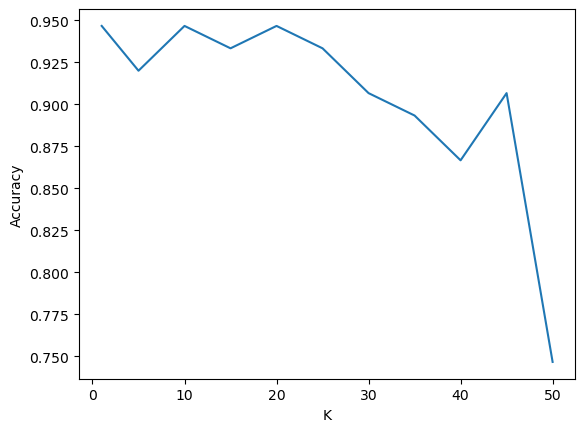

In [135]:
import matplotlib.pyplot as plt

error_curve = np.array(error_curve)
plt.plot(error_curve[:, 0], error_curve[:, 1])
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show()